# CISC/CMPE 452/COGS 400 Assignment 1 - Perceptron (10 points)  

Please put your name and student id here

    Jackson Kehoe, #20105920

- The notebook file has clearly marked blocks where you are expected to write code. Do not write or modify any code outside of these blocks.
- Make sure to restart and run all the cells from the beginning before submission. Do not clear out the outputs.
- Mark will be deducted based on late policy (-1% of the course total marks per day after due date until the end date after which no assignments will be accepted)



### Build Model (6 points)  
Implement **Simple Feedback Learning** for emotion classification (dataset from: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp)

Use the correct/incorrect feedback and info about (y>d) or (y<d) to change weights.  
Refer to the **Perceptron slides**  

- 1. Implement forward and calculate the output (2 point)  
- 2. Update the weights and bias (2 points)  
- 3. Predict function (1 point)  
- 4. Activation function (1 point)  

### Evaluator Function (2 point)  
Implement the evaluator function with Pytorch or Numpy only   
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Train and Evaluate the Model (2 point)  
Train the model with customized learning rate and number of iterations  
Use the predict function to predict the labels with the test dataset  
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score


In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [190]:
# load dataset
df_train = pd.read_csv('data/train.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('data/test.txt', names=['Text', 'Emotion'], sep=';')

In [191]:
x_train = df_train['Text']
y_train = df_train['Emotion']

x_test = df_test['Text']
y_test = df_test['Emotion']

df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [192]:
df_train.Emotion.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

## Data Preprocessing

In [193]:
# encode label
y_train = y_train.replace({'joy':1, 'sadness':0, 'anger':0, 'fear':0, 'love':1, 'surprise':1})
y_test = y_test.replace({'joy':1, 'sadness':0, 'anger':0, 'fear':0, 'love':1, 'surprise':1})

In [194]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5)#, stop_words='english')

# We transform each text into a vector
x_train = tfidf.fit_transform(x_train).toarray()
x_test = tfidf.transform(x_test).toarray()

In [195]:
def evaluator(y_test, y_pred):
    ####################################################################################################
    # enter code here to implement the evaluation matrices including confusion matrix, accuracy, precision and recall
    # DO NOT use any python packages such as scikit-learn 
    
    #calculating metrics:
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i, j in zip(y_test, y_pred):
        #true positive:
        if(i == 1 and j == 1):
            TP = TP + 1

        #false positive:
        if(i == 0 and j == 1):
            FP = FP + 1

        #true negative:
        if(i == 0 and j == 0):
            TN = TN + 1

        #false negative:
        if(i == 1 and j == 0):
            FN = FN + 1
        
    #confusion matrix:
    confusion_matrix = [TP, FP,
                       FN, TN]
    print(confusion_matrix)
    print('           Positive     Negative\n\n' + 'Positive      ' + str(TP) + '           ' + str(FP) +'\n\n' + 'Negative      ' + str(FN) + '           ' + str(TN) + '\n')
    
    #accuracy:
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    print('The accuracy of the model is: ', str(accuracy) + '\n')
    
    #precision:
    precision = TP/(TP+FP)
    print('The precison of the model is: ', str(precision) + '\n')
    
    #recall:
    recall = TP/(TP+FN)
    print('The recall of the model is: ', str(recall) + '\n')
    
    #f-measure:
    f_measure = 2*precision*recall/(precision+recall)
    print('The f-measure of the model is: ', str(f_measure) + '\n')

    ####################################################################################################

In [196]:
class SimpleFeedbackLearning(object):
    def __init__(self):
        self.history = {}
        self.history['train_acc'] = []
        self.history['test_acc'] = []
        
    def f(self, x):
        ####################################################################################################
        # 4. enter code here to implement the activation function
        if(x >= 0.5):
            fx = 1
        else:
            fx = 0
        ####################################################################################################
        return fx
    
    def train(self, x, y, x_test, y_test, learning_rate=0.1, n_iters=10, verbose=True):
        n_train, input_size = x.shape
        n_test = x_test.shape[0]
        # weight initialization
        self.W = np.zeros(input_size)
        self.b = np.zeros(1)

        for i in range(n_iters):
            for xi, yi in zip(x, y): 
                # forward
                ####################################################################################################
                # 1. enter code here to calculate the output
                a = np.dot(xi,self.W) + self.b
                act = self.f(a) 
                 ####################################################################################################

                ####################################################################################################
                # 2. enter code here to adjust the weights and bias
                if(act>yi):
                    self.W = self.W - learning_rate*xi
                    self.b = self.b - learning_rate
                if(act<yi):
                    self.W = self.W + learning_rate*xi
                    self.b = self.b + learning_rate
                    
                ####################################################################################################

            train_acc = (self.predict(x) == y).sum() / n_train
            test_acc = (self.predict(x_test) == y_test).sum() / n_test
            self.history['train_acc'].append(train_acc)
            self.history['test_acc'].append(test_acc)
            if verbose:
                print('epoch %d, train acc %.4f, test acc %.4f' % (i + 1, train_acc, test_acc))

    def predict(self, x):
        ####################################################################################################
        # 3. enter code here to complete the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels
        y_pred = []
        for xi in x:
            a = np.dot(xi, self.W) + self.b
            y_pred.append(self.f(a))
       ####################################################################################################
        return y_pred

In [207]:
####################################################################################################
# enter code here to initialize and train the model
model1 = SimpleFeedbackLearning()
model1.train(x_train, y_train, x_test, y_test, learning_rate=0.05, n_iters=15, verbose=True)
y_pred = model1.predict(x_test)

####################################################################################################


epoch 1, train acc 0.8347, test acc 0.8195
epoch 2, train acc 0.9402, test acc 0.9235
epoch 3, train acc 0.9321, test acc 0.9135
epoch 4, train acc 0.9361, test acc 0.9155
epoch 5, train acc 0.9436, test acc 0.9230
epoch 6, train acc 0.9640, test acc 0.9305
epoch 7, train acc 0.9584, test acc 0.9380
epoch 8, train acc 0.9538, test acc 0.9330
epoch 9, train acc 0.9713, test acc 0.9390
epoch 10, train acc 0.9759, test acc 0.9355
epoch 11, train acc 0.9794, test acc 0.9360
epoch 12, train acc 0.9818, test acc 0.9400
epoch 13, train acc 0.9808, test acc 0.9410
epoch 14, train acc 0.9763, test acc 0.9365
epoch 15, train acc 0.9836, test acc 0.9425


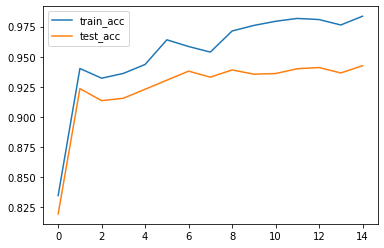

In [208]:
# plot the accuracy
plt.plot(model1.history['train_acc'], label='train_acc')
plt.plot(model1.history['test_acc'], label='test_acc')
plt.legend()
plt.show()

In [209]:
####################################################################################################
# enter code here to evaluate the model with the evaluator function
evaluator(y_test, y_pred)
####################################################################################################

[882, 77, 38, 1003]
           Positive     Negative

Positive      882           77

Negative      38           1003

The accuracy of the model is:  0.9425

The precison of the model is:  0.9197080291970803

The recall of the model is:  0.9586956521739131

The f-measure of the model is:  0.9387972325705163

